In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import math
import os, sys
sys.path.append(os.path.relpath("../src"))
from kitaev_chain import kitaev_chain_model, quench_simulation, U
FFwriter=FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
from utils import intersections, to_n, s0, sx, sy, sz, maj_ordered, tensor_product, canon_eigen, expm, c, zero, LOSCHMIDT_BDG, LOSCHMIDT_TFIM, STATES, plot_complex_matrix, gamma_n

In [38]:
def fermion_chain_from_spin_chain_params_parrallel_field(n_sites, J, h_z, h_edges_x):
    n = n_sites + 2
    mu = np.ones(n) * h_z; mu[0] = mu[-1] = 0
    t = np.ones(n - 1) * J; t[0] = t[-1] = h_edges_x
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, True)
def fermion_chain_from_spin_chain_params(n, J, h_z, h_edges_x):
    mu = np.ones(n) * h_z
    t = np.ones(n - 1) * J
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, False)

def are_bdg_conj(state1_, state2_):
    n = len(state1_) // 2
    state2 = state2_.flatten()
    state1 = state1_.flatten()[[list(range(n, 2 * n)) + list(range(n))]].conj().flatten()
    for i in range(n):
        if np.abs(state1[i]) > 1e-3:
            state1 /= state1[i]
            break
    for i in range(n):
        if np.abs(state2[i]) > 1e-3:
            state2 /= state2[i]
            break
    plt.show()
    return np.allclose(state1, state2)


In [39]:
n = 20
m = n + 2
H0 = fermion_chain_from_spin_chain_params_parrallel_field(n, 1, 1, h_edges_x=50)
H = fermion_chain_from_spin_chain_params_parrallel_field(n, 1, 1, h_edges_x=0)
H0.bdg_eigen()
H.bdg_eigen()
u = U(H)
G_D = gamma_n(m).conj().T

In [40]:
high_energy_states = H0.bdg_evecs_sorted[:,[m - 2, m - 1, -2, -1]]
zero_energy_states = H0.bdg_evecs_sorted[:,[0, m]]

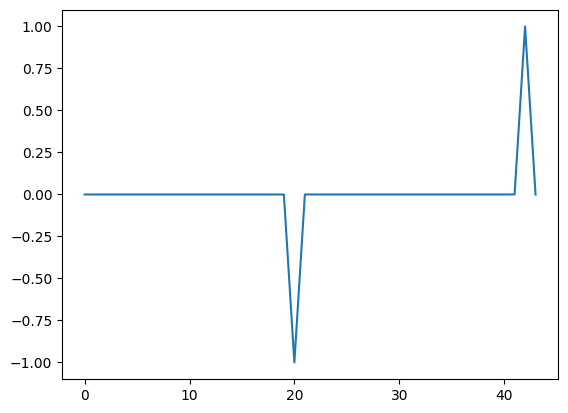

In [41]:
plt.plot(high_energy_states[:,0] - high_energy_states[:,2])

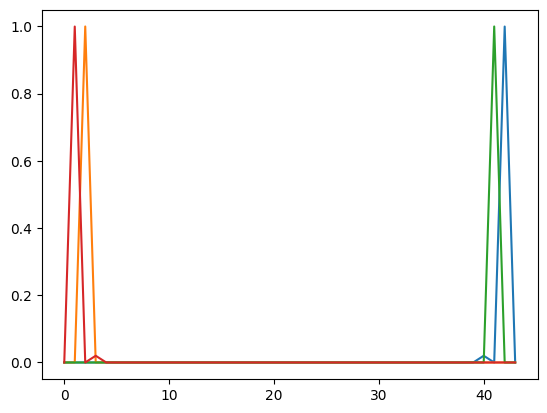

In [42]:
high_energy_states = H0.bdg_evecs_sorted[:,[m - 2, m - 1, 2 * m - 2,2 * m - 1]]
high_energy_maj = 0.5 ** 0.5 * np.hstack(
    [high_energy_states[:, :2] + high_energy_states[:, 2:],
     1j * (high_energy_states[:, :2] - high_energy_states[:, 2:])])

for line in (G_D@(high_energy_maj)).T:
    plt.plot(np.abs(line))


In [43]:
cycle = 2.1 * m
duration = 5 * cycle
dt = m / 20
t_range = np.arange(0, duration, dt)
gamma_sim = [
    np.vstack([G_D@(u(t) @
                    maj
                    ) for t in t_range]).T
for maj in high_energy_maj.T
]
loschmidt_sim = np.array([np.abs(
            np.linalg.det(
                H0.bdg_evecs_sorted[:, :m].T.conj() @ u(t) @ H0.bdg_evecs_sorted[:, :m]
                )
            ) for t in t_range])


In [44]:
color = np.zeros((4, 3))
color[:3,:] = np.eye(3)
color[3,:2] = 1
#color = color[[]]

image = np.permute_dims(
    sum(
        np.kron(color[i].reshape((3, 1, 1)),np.abs(gamma_sim[i]))
        for i in range(4)
    )
, (1,2,0))

(0.0, 229.9)

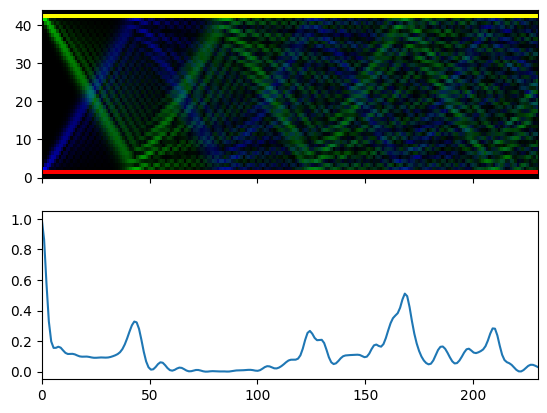

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# map image columns to the t_range x-coordinates
xmin, xmax = t_range[0], t_range[-1]
ax1.imshow(image, aspect='auto', interpolation='nearest', extent=(xmin, xmax, 0, image.shape[0]), origin='upper')

# plot with the same x coordinates
ax2.plot(t_range, np.abs(loschmidt_sim))

# ensure both axes use the same x-limits
ax2.set_xlim(xmin, xmax)